In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns
from PIL import Image

#tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#show images using OpenCV
from google.colab.patches import cv2_imshow

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#load the image file of the dataset
images = np.load('/content/drive/MyDrive/Plantseedling/images.npy')

#load the labels of teh dataset
labels = pd.read_csv('/content/drive/MyDrive/Plantseedling/Labels.csv')

labels.shape

(4750, 1)

the label is 2D array. It contains 4750 samples with each having 1 feature

In [ ]:
images.shape

(4750, 128, 128, 3)

the image is 4D array. It contains 4750 samples, each having height of  128 pixel and width of 128 pixels and 3 channels (red blue and green)

In [ ]:
labels['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [ ]:
#Data shape
print(images.shape)
print(labels.shape)


(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB images of shape 128 x 128 x 3, each having 3 channels

Plotting images using OpenCV and matplotlib

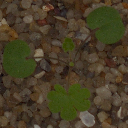

In [ ]:

#use openCV to view image
cv2_imshow(images[1])

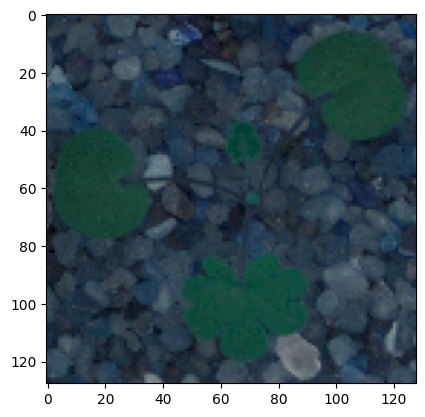

In [ ]:
#use matplotlib to view the image
plt.imshow(images[1])

In [ ]:
#converting images from BGR to RGB using cvtColor
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

Exploratory Data Analysis

In [ ]:
#unique varieties
labels["Label"].nunique()

12

There are 12 categories in the dataset

In [ ]:
labels['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

In [ ]:
labels['Label'].isnull().sum()

0

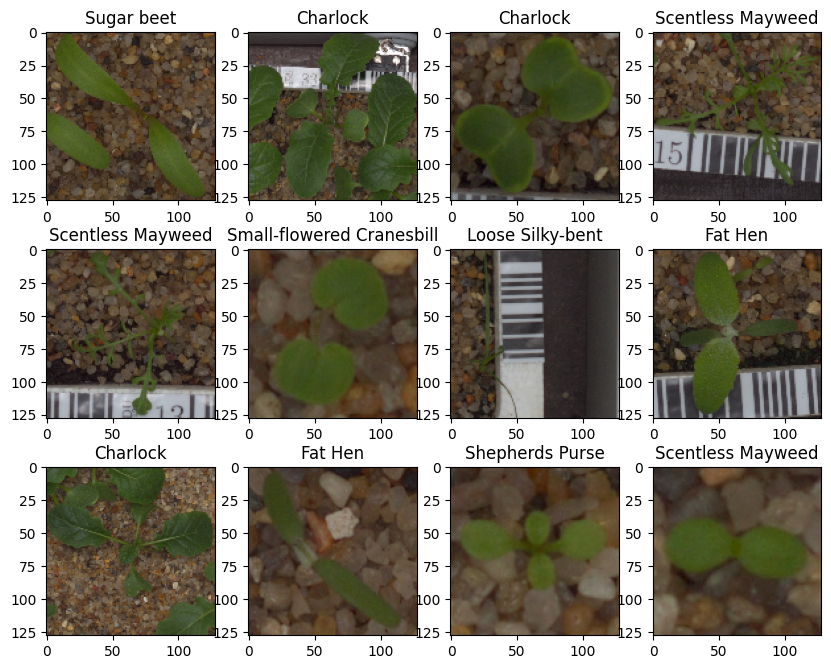

In [ ]:
num_classes = 12

num_classes = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed",
       "Common wheat", "Fat Hen", "Loose Silky-bent", "Maize",
       "Scentless Mayweed", "Shepherds Purse",
       "Small-flowered Cranesbill", "Sugar beet"]

keys =dict(labels['Label'])
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 8))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(images[random_index, :])
        ax.set_title(keys[random_index])
plt.show()


In [ ]:
import seaborn as sns

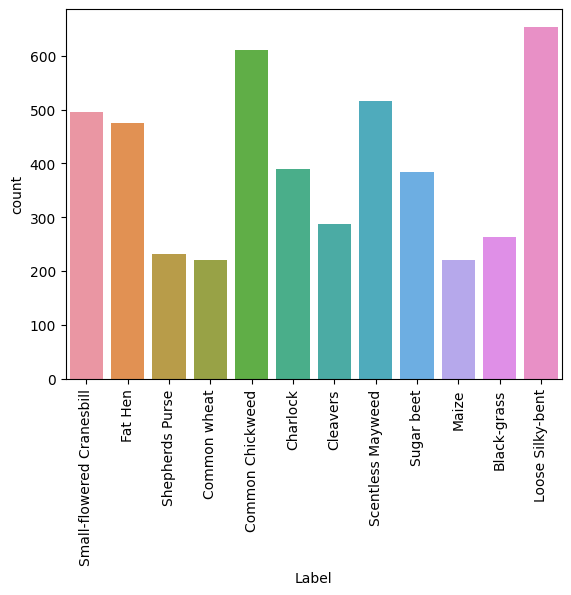

In [ ]:
sns.countplot(x = 'Label', data = labels)
plt.xticks(rotation = 90);

loose silky bent and common chickweed have the highest number of occurence while common wheat is the least

Resize image

In [ ]:
#Resize image
images_decreased = []
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation = cv2.INTER_LINEAR))


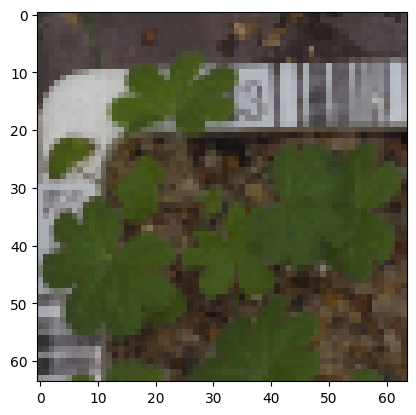

In [ ]:
plt.imshow(images_decreased[3])

Denoise using Gaussian bar

In [ ]:
images_gb = []
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize = (3,3), sigmaX = 0))


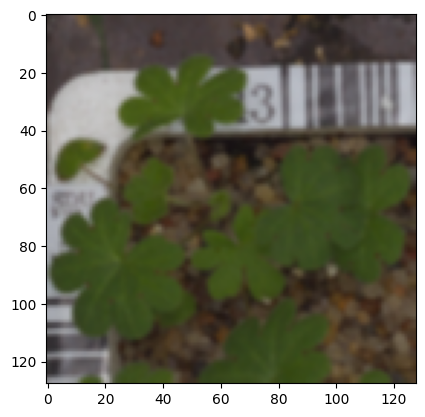

In [ ]:
plt.imshow(images_gb[3])

Split the data

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=42, stratify= labels)
X_train, X_val, y_train, y_val =train_test_split(X_temp, y_temp, test_size=0.1, random_state=42, stratify= y_temp)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


LabelBinarizer

In [ ]:
from sklearn.preprocessing import LabelBinarizer

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)
y_test_encoded = enc.transform(y_test)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


Normalization

In [ ]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

CNN

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session

<function keras.backend.clear_session()>

In [ ]:
#fix seed for random gen
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Build model
model = Sequential()

#add first convolution layer with 128 filters and 3 by 3 kernels
model.add(Conv2D(128, (3,3), padding = "same", input_shape = (64, 64, 3), activation = "relu"  ))

#add maxpooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#add second convolution layer with 64 filters and 3 by 3 kernel
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))

#add max pooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#flatten
model.add(Flatten())

#add fully connected layer
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))

#add output layer
model.add(Dense(12,activation = 'softmax'))

#using adam optimizer
opt = Adam()

Compile model

In [ ]:
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#Generate model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                        

Early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
modelfilename = "/content/drive/MyDrive/Plantseedling/Plant.hdf5/"

In [ ]:
es = EarlyStopping(monitor = "val_loss", patience = 4, mode = "min", verbose = 1)
chkpt = ModelCheckpoint(modelfilename, verbose = 1, save_best_only = True)

Fitting the model on the train data

In [ ]:
history = model.fit(
          X_train_normalized, y_train_encoded,
          epochs = 10,
          validation_data = (X_val_normalized, y_val_encoded),
          batch_size = 32,
          verbose = 2,
          callbacks = [es]
)

Epoch 1/10
121/121 - 123s - loss: 1.9997 - accuracy: 0.3715 - val_loss: 6.1453 - val_accuracy: 0.0467 - 123s/epoch - 1s/step
Epoch 2/10
121/121 - 109s - loss: 1.2788 - accuracy: 0.5675 - val_loss: 10.2384 - val_accuracy: 0.0771 - 109s/epoch - 900ms/step
Epoch 3/10
121/121 - 104s - loss: 0.9818 - accuracy: 0.6610 - val_loss: 9.3215 - val_accuracy: 0.0935 - 104s/epoch - 858ms/step
Epoch 4/10
121/121 - 105s - loss: 0.7403 - accuracy: 0.7494 - val_loss: 4.3841 - val_accuracy: 0.1075 - 105s/epoch - 870ms/step
Epoch 5/10
121/121 - 103s - loss: 0.6330 - accuracy: 0.7840 - val_loss: 1.8403 - val_accuracy: 0.5234 - 103s/epoch - 852ms/step
Epoch 6/10
121/121 - 105s - loss: 0.5192 - accuracy: 0.8110 - val_loss: 1.7290 - val_accuracy: 0.5537 - 105s/epoch - 870ms/step
Epoch 7/10
121/121 - 102s - loss: 0.4149 - accuracy: 0.8534 - val_loss: 1.9216 - val_accuracy: 0.5678 - 102s/epoch - 846ms/step
Epoch 8/10
121/121 - 112s - loss: 0.3397 - accuracy: 0.8846 - val_loss: 3.7897 - val_accuracy: 0.4813 - 11

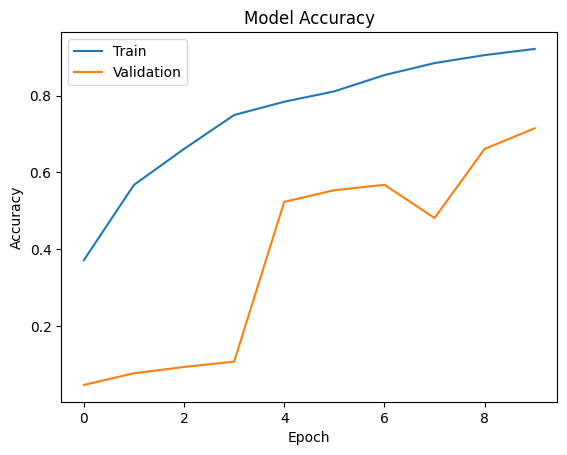

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

15/15 - 4s - loss: 1.2856 - accuracy: 0.6737 - 4s/epoch - 268ms/step


The model appears to improve with increasing epoch however it is observed that the loss accuracy is rised as the number of epoch increased but subsequently dipped before increasing again.
Increasing the number of epoch may be considered during hyperparameter tuning.

Model 2

In [ ]:
#clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#rescaling all images
train_datagen = ImageDataGenerator(
                              rotation_range = 180,
                              fill_mode = 'nearest',
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range = 0.2,
                              zoom_range = 0.2,

                              )

In [ ]:
#Build model
model = Sequential()

#add first convolution layer with 128 filters and 3 by 3 kernels
model.add(Conv2D(128, (3,3), padding = "same", input_shape = (64, 64, 3), activation = "relu"  ))

#add maxpooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#add second convolution layer with 64 filters and 3 by 3 kernel
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))

#add max pooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#flatten
model.add(Flatten())

#add fully connected layer with drop out changed to 0.5
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))

#add output layer
model.add(Dense(12,activation = 'softmax'))

#using adam optimizer
opt = Adam()

In [ ]:
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                        

In [ ]:
modelfilename2 = "/content/drive/MyDrive/Plantseedling/Plant2.hdf5"
chkpt2 = ModelCheckpoint(modelfilename2, verbose = 1, save_best_only = True)

In [ ]:
epochs = 50
batch_size = 64

#create generator for training data
train_generator = train_datagen.flow(
    X_train_normalized,
    y_train_encoded,
    batch_size = batch_size,
    seed =42,
    shuffle = True
)

#train model using generator
history2 = model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch = X_train_normalized.shape[0] // batch_size,
    validation_data = (X_val_normalized, y_val_encoded),
    verbose = 1,
    callbacks = [es, chkpt2]
)

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 2.1020 - accuracy: 0.3273
Epoch 1: val_loss improved from inf to 4.15332, saving model to /content/drive/MyDrive/Plantseedling/Plant2.hdf5
60/60 [==============================] - 113s 2s/step - loss: 2.1020 - accuracy: 0.3273 - val_loss: 4.1533 - val_accuracy: 0.0561
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 1.5322 - accuracy: 0.4843
Epoch 2: val_loss did not improve from 4.15332
60/60 [==============================] - 107s 2s/step - loss: 1.5322 - accuracy: 0.4843 - val_loss: 7.2735 - val_accuracy: 0.0561
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 1.3162 - accuracy: 0.5461
Epoch 3: val_loss did not improve from 4.15332
60/60 [==============================] - 117s 2s/step - loss: 1.3162 - accuracy: 0.5461 - val_loss: 10.8263 - val_accuracy: 0.0561
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 1.2035 - accuracy: 0.5969
Epoch 4: val_loss did not 

Data augmentation was introduced to improve the model but the model did not improve.

Model 3

In [ ]:
#clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Build model
model = Sequential()

#add first convolution layer with 128 filters and 3 by 3 kernels
model.add(Conv2D(32, (3,3), padding = "same", input_shape = (64, 64, 3), activation = "relu"  ))

#add maxpooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#add second convolution layer with 64 filters and 3 by 3 kernel
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))

#add max pooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#flatten
model.add(Flatten())

#add fully connected layer with drop out changed to 0.5
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

#add output layer
model.add(Dense(12,activation = 'softmax'))

#using adam optimizer
#learning_rate = 0.01
#rho = 0.9
#rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate, rho = rho)

opt = Adam()

In [ ]:
model.compile(optimizer = opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                        

In [ ]:
#es = EarlyStopping(monitor = "val_loss", patience = 4, mode = "min", verbose = 1)
chkpt3 = ModelCheckpoint(modelfilename3, verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(
          X_train_normalized, y_train_encoded,
          epochs = 10,
          validation_data = (X_val_normalized, y_val_encoded),
          batch_size = 32,
          verbose = 2,
          callbacks = [es]
)

Epoch 1/10
121/121 - 35s - loss: 2.4627 - accuracy: 0.2454 - val_loss: 4.0996 - val_accuracy: 0.1379 - 35s/epoch - 286ms/step
Epoch 2/10
121/121 - 35s - loss: 1.8847 - accuracy: 0.3468 - val_loss: 6.1392 - val_accuracy: 0.0561 - 35s/epoch - 289ms/step
Epoch 3/10
121/121 - 33s - loss: 1.6966 - accuracy: 0.4102 - val_loss: 7.4467 - val_accuracy: 0.0561 - 33s/epoch - 273ms/step
Epoch 4/10
121/121 - 33s - loss: 1.5759 - accuracy: 0.4310 - val_loss: 2.1494 - val_accuracy: 0.2593 - 33s/epoch - 275ms/step
Epoch 5/10
121/121 - 32s - loss: 1.4884 - accuracy: 0.4819 - val_loss: 1.5403 - val_accuracy: 0.4696 - 32s/epoch - 268ms/step
Epoch 6/10
121/121 - 37s - loss: 1.2875 - accuracy: 0.5344 - val_loss: 2.0553 - val_accuracy: 0.4369 - 37s/epoch - 302ms/step
Epoch 7/10
121/121 - 33s - loss: 1.2029 - accuracy: 0.5732 - val_loss: 1.5876 - val_accuracy: 0.5117 - 33s/epoch - 272ms/step
Epoch 8/10
121/121 - 32s - loss: 1.0898 - accuracy: 0.6127 - val_loss: 1.4594 - val_accuracy: 0.5678 - 32s/epoch - 268

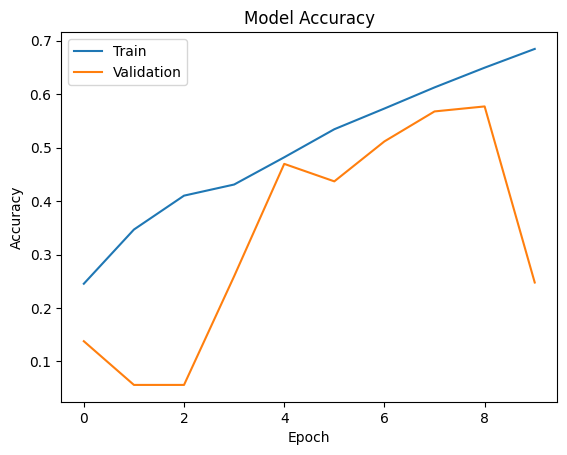

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

using 32filters in the first layer, 64filters in the second layer
and 128 in the fully connected layer, the model showed improvement but dipped at the end

Model 4

In [ ]:
#clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Build model
model = Sequential()

#add first convolution layer with32 filters and 5 by 5 kernels
model.add(Conv2D(16, (5,5), padding = "same", input_shape = (64, 64, 3), activation = "relu"  ))


#add maxpooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#add second convolution layer with 32 filters and 5 by 5 kernel
model.add(Conv2D(32, (5,5), padding = 'same', activation = 'relu'))

#add max pooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#add third convolution layer with 64 filters and 5 by 5 kernel
model.add(Conv2D(64, (5,5), padding = 'same', activation = 'relu'))

#add max pooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#add fourth convolution layer with 128 filters and 5 by 5 kernel
#model.add(Conv2D(64, (5,5), padding = 'same', activation = 'relu'))

#add max pooling to reduce size of output
#model.add(MaxPooling2D(2,2))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

#flatten
model.add(Flatten())

#add fully connected layer with drop out changed to 0.2
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

#add output layer
model.add(Dense(12,activation = 'softmax'))

#using adam optimizer
#learning_rate = 0.01
#rho = 0.9
#rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate, rho = rho)

opt = Adam()

In [ ]:
model.compile(optimizer = opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0

In [ ]:
modelfilename4 = "/content/drive/MyDrive/Plantseedling/Plant4.hdf5/"

In [ ]:
chkpt4 = ModelCheckpoint(modelfilename4, verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(
          X_train_normalized, y_train_encoded,
          epochs = 10,
          validation_data = (X_val_normalized, y_val_encoded),
          batch_size = 32,
          verbose = 2,
          callbacks = [es, chkpt4]
)

Epoch 1/10

Epoch 1: val_loss improved from inf to 4.68880, saving model to /content/drive/MyDrive/Plantseedling/Plant4.hdf5/


121/121 - 49s - loss: 1.9266 - accuracy: 0.3702 - val_loss: 4.6888 - val_accuracy: 0.1075 - 49s/epoch - 407ms/step
Epoch 2/10

Epoch 2: val_loss did not improve from 4.68880
121/121 - 45s - loss: 1.1537 - accuracy: 0.5992 - val_loss: 6.0815 - val_accuracy: 0.1706 - 45s/epoch - 375ms/step
Epoch 3/10

Epoch 3: val_loss improved from 4.68880 to 3.80729, saving model to /content/drive/MyDrive/Plantseedling/Plant4.hdf5/


121/121 - 45s - loss: 0.9169 - accuracy: 0.6842 - val_loss: 3.8073 - val_accuracy: 0.2640 - 45s/epoch - 371ms/step
Epoch 4/10

Epoch 4: val_loss improved from 3.80729 to 2.74672, saving model to /content/drive/MyDrive/Plantseedling/Plant4.hdf5/


121/121 - 46s - loss: 0.7367 - accuracy: 0.7349 - val_loss: 2.7467 - val_accuracy: 0.3808 - 46s/epoch - 377ms/step
Epoch 5/10

Epoch 5: val_loss improved from 2.74672 to 1.45611, saving model to /content/drive/MyDrive/Plantseedling/Plant4.hdf5/


121/121 - 45s - loss: 0.6384 - accuracy: 0.7764 - val_loss: 1.4561 - val_accuracy: 0.5584 - 45s/epoch - 374ms/step
Epoch 6/10

Epoch 6: val_loss did not improve from 1.45611
121/121 - 43s - loss: 0.5177 - accuracy: 0.8214 - val_loss: 1.9854 - val_accuracy: 0.5140 - 43s/epoch - 352ms/step
Epoch 7/10

Epoch 7: val_loss did not improve from 1.45611
121/121 - 43s - loss: 0.4668 - accuracy: 0.8287 - val_loss: 2.0986 - val_accuracy: 0.5070 - 43s/epoch - 353ms/step
Epoch 8/10

Epoch 8: val_loss improved from 1.45611 to 0.83792, saving model to /content/drive/MyDrive/Plantseedling/Plant4.hdf5/


121/121 - 48s - loss: 0.4076 - accuracy: 0.8498 - val_loss: 0.8379 - val_accuracy: 0.7453 - 48s/epoch - 393ms/step
Epoch 9/10

Epoch 9: val_loss did not improve from 0.83792
121/121 - 43s - loss: 0.3473 - accuracy: 0.8737 - val_loss: 1.0037 - val_accuracy: 0.7383 - 43s/epoch - 354ms/step
Epoch 10/10

Epoch 10: val_loss did not improve from 0.83792
121/121 - 42s - loss: 0.3128 - accuracy: 0.8856 - val_loss: 1.6989 - val_accuracy: 0.6379 - 42s/epoch - 350ms/step


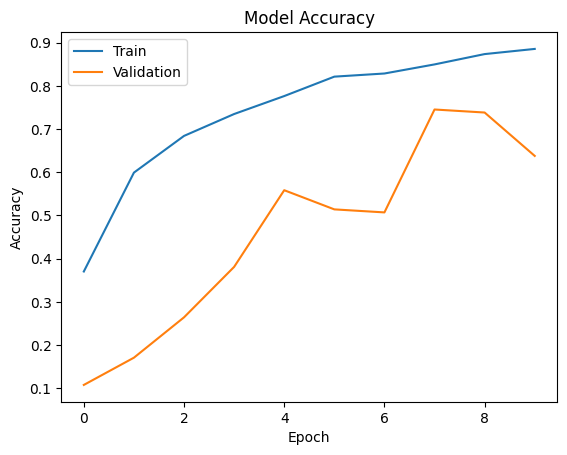

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

introduced a third convolution layer and starting with sixteen filters, followed by another 32 and then 64 filters; it seemed to improve the model a bit

Evaluate the model on test data

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

15/15 - 1s - loss: 1.7739 - accuracy: 0.6021 - 1s/epoch - 77ms/step


Generating the predictions using test data

In [ ]:
y_pred = model.predict(X_test_normalized)

15/15 [==============================] - 1s 76ms/step


Confusion matrix

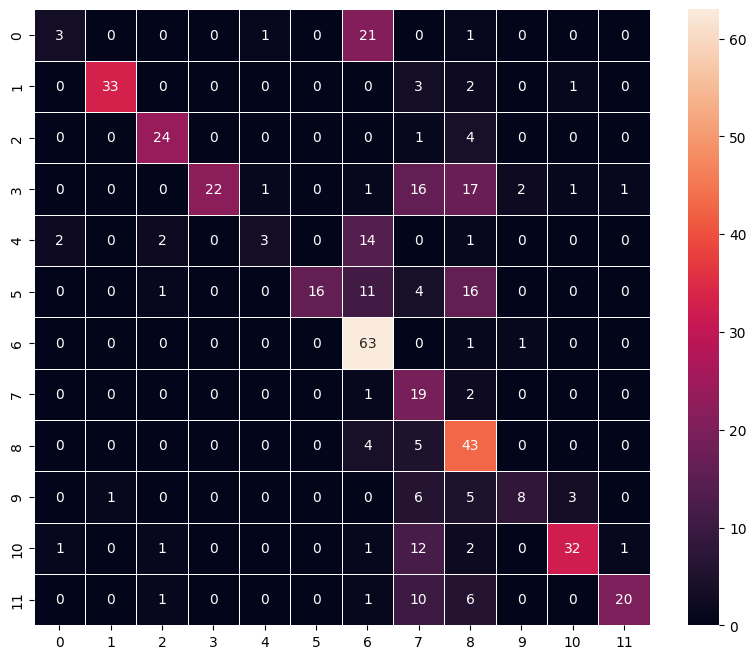

In [ ]:
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)
plt.show()

rows 0,3, ,10, 11 did not classify well

In [ ]:
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

y_test_arg

array([ 3, 10, 10, 10,  1, 10, 11,  6, 10, 10,  6,  3,  4, 10,  3,  1,  4,
        0,  7,  7, 10,  5,  5,  1,  6,  7,  3,  6,  2,  5,  9,  7,  6,  2,
        0,  6,  9,  6,  0,  8,  0,  3, 11, 10,  3,  3,  5, 10,  7,  3,  1,
        3,  0, 10,  7,  9,  8,  1,  3,  3,  6, 10,  8, 10, 11,  0,  5,  5,
        3, 10,  3, 10, 11,  6, 10,  1,  8,  9,  2,  6,  1, 11,  4, 11,  7,
        1,  3,  9,  7,  6,  8,  6, 10, 11,  8,  6,  9,  9,  1, 10,  6, 10,
       11,  5, 10,  3,  8,  6, 10,  3, 11,  3,  8,  2,  5,  0,  8,  3,  1,
       10,  3,  0,  5,  5,  2,  3,  0,  6,  9,  7,  0,  6,  8,  5,  6,  1,
        6,  6, 11,  6, 11,  6,  8,  5,  8,  9,  4,  3, 10,  1,  5,  1,  9,
        7, 10,  3,  8,  6,  6,  6,  8,  5,  0,  8,  3,  8,  1,  8, 11, 10,
        1,  4,  3,  6,  6, 11,  8,  5,  7, 11,  4,  6,  8,  4,  1,  6,  1,
        3, 10,  4,  1,  2,  6,  3,  6,  2,  3,  0, 11,  5,  1,  3,  1,  7,
        6,  8,  3,  1, 10,  3,  5,  6,  3,  2,  6,  6,  5, 11, 11,  2,  2,
        1,  2,  9,  9,  6

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test_arg, y_pred_arg)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.12      0.19        26
           1       0.97      0.85      0.90        39
           2       0.83      0.83      0.83        29
           3       1.00      0.36      0.53        61
           4       0.60      0.14      0.22        22
           5       1.00      0.33      0.50        48
           6       0.54      0.97      0.69        65
           7       0.25      0.86      0.39        22
           8       0.43      0.83      0.57        52
           9       0.73      0.35      0.47        23
          10       0.86      0.64      0.74        50
          11       0.91      0.53      0.67        38

    accuracy                           0.60       475
   macro avg       0.72      0.57      0.56       475
weighted avg       0.75      0.60      0.59       475



Transfer learning

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:

from keras.utils.layer_utils import validate_string_arg
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top= False, input_shape=(64, 64, 3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
#making all layers non trainable
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Nadam, Adagrad

new_model = Sequential()

#add convolutional part of vgg16
new_model.add(vgg_model)

#flatten
new_model.add(Flatten())

#add dense output layer
new_model.add(Dense(50, activation = 'relu'))
#new_model.add(Dense(20, activation = 'relu'))
#new_model.add(Dense(64, activation = 'relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(20, activation = 'relu'))
new_model.add(Dense(12, activation = 'softmax'))

opt = Adam()

new_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 50)                102450    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 12)                252       
                                                                 
Total params: 14,818,410
Trainable params: 103,722
Non-t

In [ ]:
modelfilename5 = '/content/drive/MyDrive/Plantseedling/Plant5.hdf5'

In [ ]:
chkpt5 = ModelCheckpoint(modelfilename5, verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(
          X_train_normalized, y_train_encoded,
          epochs = 15,
          validation_data = (X_val_normalized, y_val_encoded),
          batch_size = 32,
          verbose = 2,
          callbacks = [es, chkpt5]
)

Epoch 1/15

Epoch 1: val_loss improved from inf to 1.16734, saving model to /content/drive/MyDrive/Plantseedling/Plant5.hdf5
121/121 - 61s - loss: 0.2494 - accuracy: 0.9041 - val_loss: 1.1673 - val_accuracy: 0.7336 - 61s/epoch - 503ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 1.16734
121/121 - 64s - loss: 0.1998 - accuracy: 0.9257 - val_loss: 1.5408 - val_accuracy: 0.6916 - 64s/epoch - 532ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 1.16734
121/121 - 52s - loss: 0.1452 - accuracy: 0.9493 - val_loss: 1.6893 - val_accuracy: 0.6028 - 52s/epoch - 427ms/step
Epoch 4/15

Epoch 4: val_loss improved from 1.16734 to 0.90152, saving model to /content/drive/MyDrive/Plantseedling/Plant5.hdf5
121/121 - 42s - loss: 0.1276 - accuracy: 0.9506 - val_loss: 0.9015 - val_accuracy: 0.7967 - 42s/epoch - 347ms/step
Epoch 5/15

Epoch 5: val_loss did not improve from 0.90152
121/121 - 42s - loss: 0.1229 - accuracy: 0.9553 - val_loss: 2.4875 - val_accuracy: 0.5724 - 42s/epoch - 348ms

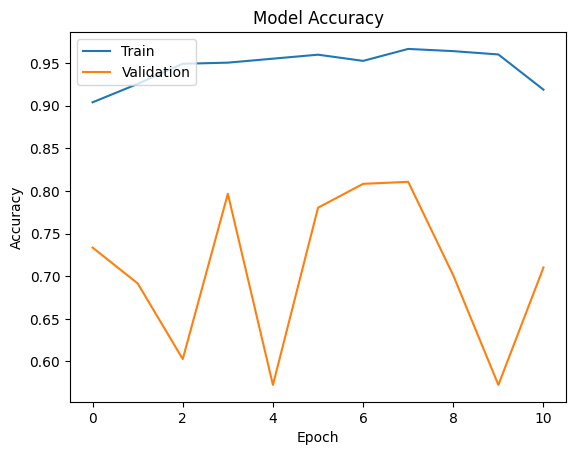

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

introducing a baseline model didnt make a difference, model 1 and 4  appears to be good.
